## Introduction to Tensorflow

- Simple linear regression with Tensorflow.
  - Fit a linear regression line
  - Classify images
- Visualizing Training Progress with Tensorboard.
- Re-using models - Pretrained models from Tensorflow Model Hub
  - Fine tune an image model to classify images

In [88]:
# ! pip install -q seaborn tensorflow_hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


## Utility Functions

Implement a few utility functions which we will use across the notebook

In [89]:
# plot model training history
def plot_history(history):
    
    metrics =  [x for x in history.history.keys() if "val" not in x]
    # metrics = list(history.history.keys())
    ncols = 2
    nrows = int(np.ceil(len(metrics)/ncols))  
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,nrows*6) )
    fig.suptitle(f"Model Training History" )
    i = 0 
    if ax.ndim == 1:
        ax = ax.reshape(ax.shape[0],1) 
    for row in ax:
        for col in row:
            col.plot(history.history[metrics[i]])
            col.plot(history.history["val_"+metrics[i]])
            col.set_xlabel("Epoch")
            col.set_ylabel(f"{metrics[i]}")
            col.legend(['train', 'val'], loc='upper right')
            col.title.set_text(f"{metrics[i]}")
            i += 1
    plt.tight_layout()
    plt.rcParams.update({'font.size': 18})  
    
    plt.show()

# download data file
def download_file(url): 
  download_path = f'/tmp/{url.split("/")[-1]}'
  results = requests.get(url)
  with open(download_path, 'wb') as f:
      f.write(results.content)
  return download_path

# Linear Regression with Tensorflow 

Based on Tensorflow tutorial [here](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb).
- Download the MPG Dataset 
- Build a neural network model to predict Miles Per Gallon for a car, given its properties.

In [90]:
# download CSV
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

# Read csv file using pandas
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset = dataset.dropna()

# Preprocessing to replace car origin field one hot encoded variables
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

# Split dataset into train and test split
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')


# Build a feature normalization layer. Fit it on train data only
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


In [91]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


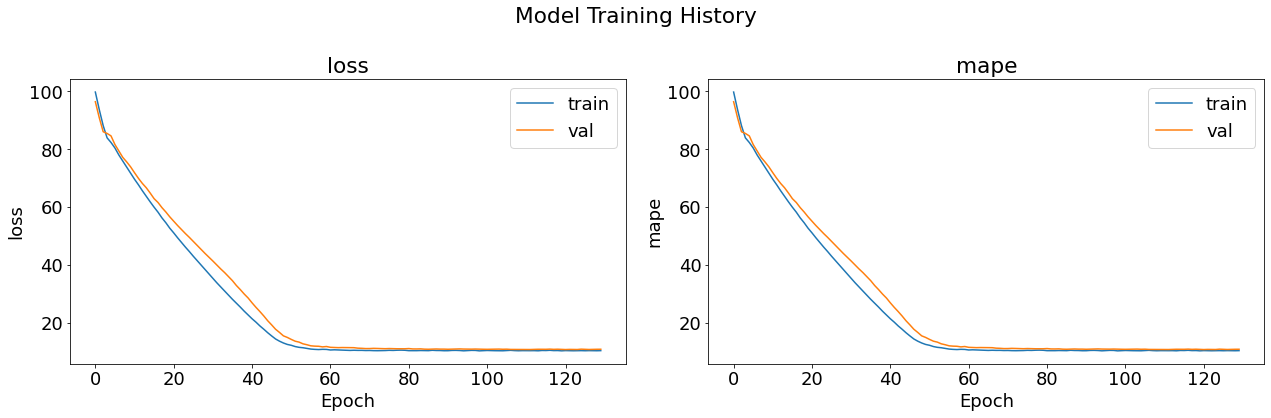

In [92]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.06),
    loss='mape', metrics=["mape"])

history = linear_model.fit(
    train_features,
    train_labels,
    verbose=0,
    epochs=130,  
    validation_split = 0.2)

plot_history(history)

## Get Predictions on Test Set

Get predictions on the test set, compare with original labels

In [93]:
predictions = linear_model.predict(test_features) 
test_preds= pd.DataFrame({"Original MPG": list(test_labels), "Predicted MPG": list(predictions.reshape(-1))})
test_preds["Percentage Difference"] = round( ( abs(test_preds["Original MPG"] - test_preds[ "Predicted MPG"]) / test_preds["Original MPG"])*100 ,2)
test_preds

,Original MPG,Predicted MPG,Percentage Difference
0,15.0,14.344485,4.37
1,10.0,9.327795,6.72
2,9.0,8.066470,10.37
3,25.0,27.019777,8.08
4,19.0,20.926760,10.14
...,...,...,...
73,34.0,27.251884,19.85
74,36.0,31.008327,13.87
75,34.0,32.229446,5.21
76,32.0,33.706100,5.33


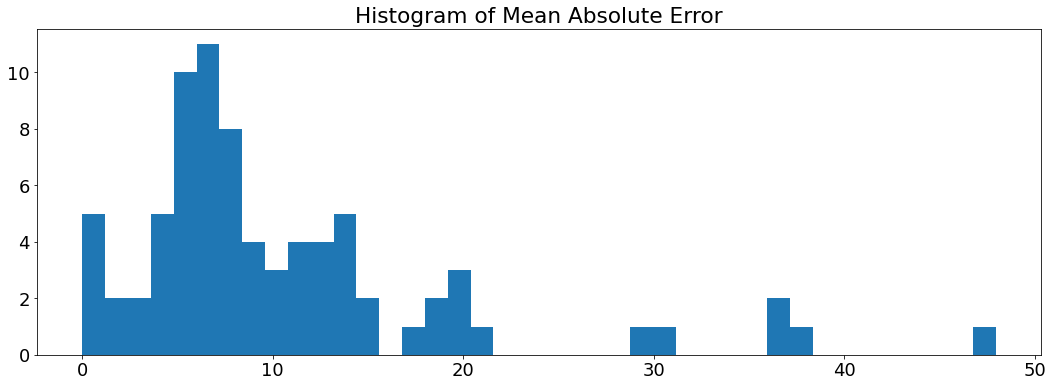

In [94]:
plt.figure(figsize=(18,6))
plt.hist(test_preds["Percentage Difference"], bins=40);
plt.title("Histogram of Mean Absolute Error");